In [1]:
# import libraries

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# read in data
df_diabetes = pd.read_csv('2014_BRFSS_post_processing.csv')
df_diabetes.head()

,general_health,10yr_age_group,bmi_category,last_checkup,income,race,mscode,flushot,employed,sex,...,mental_health_days_per_month,kidney_disease,depressive_disorder,uses_medical_equipment,rent_or_own_home,any_exercise,blindness,trouble_concentrating,diabetes,smoker
0,5-Poor,60s,25-30 (Overweight),12 or fewer months,"$\$$50,001 - $\$$75,000",Multiracial,Not in an MSA,Yes,Unable to work,Female,...,1-5,Yes,No,Yes,Own,No,Yes,No,Yes,Former smoker
1,1-Excellent,50s,30+ (Obese),12 or fewer months,"$\$$50,001 - $\$$75,000",White,Inside a suburban county of the MSA,No,Employed for wages,Male,...,0,No,No,No,Own,Yes,No,No,No,Former smoker
2,3-Good,60s,30+ (Obese),12 or fewer months,"$\$$20,001 - $\$$25,000",White,Outside the center city of an MSA but inside t...,Yes,Retired,Female,...,0,No,No,No,Own,No,No,No,No,Never smoked
3,3-Good,80+,30+ (Obese),12 or fewer months,"$\$$35,001 - $\$$50,000",Black,Inside a suburban county of the MSA,Yes,Retired,Male,...,1-5,No,No,No,Own,Yes,No,No,Yes,Never smoked
4,2-Very good,60s,25-30 (Overweight),12 or fewer months,"$\$$75,000+",White,Inside a suburban county of the MSA,No,Retired,Male,...,0,No,No,No,Own,Yes,No,No,No,Former smoker


As discussed in the section on exploratory data analysis, most of the data presented is provided in categorical form. Many of the features either do not have a consistent inverval between categories or do not have well-defined intervals at all, so when conducting statistical inference and building the machine learning model, the most intuitive way to approach the data will be to use methods well-suited to categorical data. For statistical analysis, that means starting with the chi-squared ($\chi^2$) test of significance.

In [64]:
from scipy.stats import chi2_contingency

df_pvals = pd.DataFrame()
for column1 in df_diabetes:
    chi2_list = []
    p_list = []
    dof_list = []
    for column2 in df_diabetes:
        crosstab = pd.crosstab(df_diabetes[column1], df_diabetes[column2])
        chi2, p, dof, expected = chi2_contingency(crosstab)
        p_list.append(p)
    df_pvals[column1] = p_list

In [66]:
df_p.index = df_p.columns
p_vals = df_p.values
print(p_vals[p_vals > .01])
print(np.nonzero(p_vals > .01))

[0.13806869 0.02525892 0.94994452 0.64187742 0.64187742 0.13806869
 0.02525892 0.94994452]
(array([ 7,  7,  7,  9, 16, 20, 21, 22], dtype=int64), array([20, 21, 22, 16,  9,  7,  7,  7], dtype=int64))


Running the $\chi^2$ test on all pairs of variables returns only four unique pairs that fail to reject the null hypothesis on a selected $\alpha = 0.01$, the null hypothesis being that the two selected variables are independent of each other. I opted for a lower value of $\alpha$ because I believed the relatively large sample size I'm using would otherwise make it easier to detect false positives. The pairs that fail to reject the null hypothesis ((7, 20), (7, 21), (7, 22), and (9, 16)) correspond to (`flushot`, `any_exercise`), (`flushot`, `blindness`), (`flushot`, `trouble_concentrating`), and (`sex`, `kidney_disease`). Ultimately, I am most interested in the significance of values related to the target variable, `diabetes`, and all variables related to `diabtetes` successfully reject the null hypothesis.

An additional test I can run after computing the $\chi^2$ statistics and their p-value is Cramér's V, which uses value of $\chi^2$ to compute the strength of association between two variables. This measure of association ranges from 0 to 1 and serves a similar purpose to measuring the correlation between two continuous variables, so it seems like a potentially useful tool to use on data that is entirely categorical (whether ordinal or nominal). Again, I am most interested in the strength of association between between `diabetes` and all other variables, but I have also compute Cramér's V for all other pairs since it may be useful to know how strongly associated two features are to each other when it comes time to build the machine learning model.

The bias correction operation is included in the computation of Cramér's V.

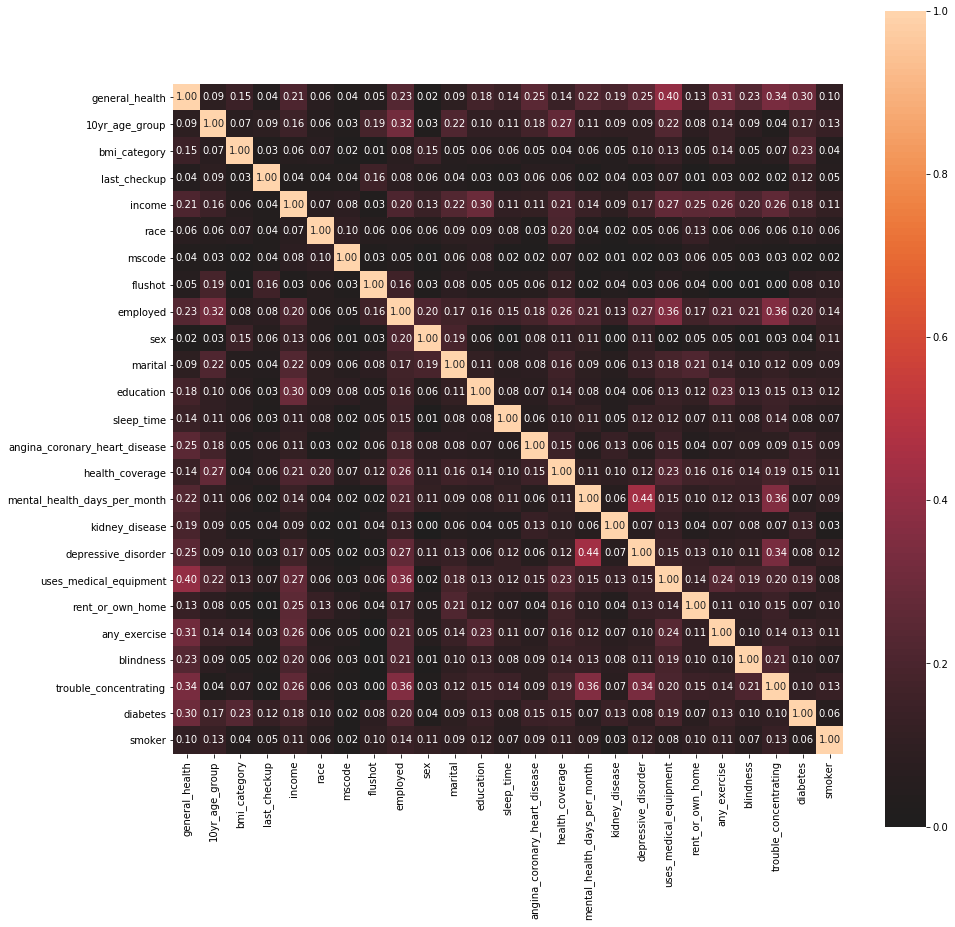

In [67]:
from dython.nominal import associations

associations(df_diabetes, figsize=(15, 15)) #Bias correction set to True by default
plt.show()

Although most pairs of features were found to likely have some association by their low p-values on the $\chi^2$ test, very few pairs of features have a strength of association higher than $0.25$. Perhaps the large sample size made it possible to be reasonably confident that even weak associations were statistically significant (recall that this is related to the reason I selected a very low p-value). Three of the four pairs of features that failed to reject the null hypothesis on the chi-squared test were also found to have a Cramér's of $0.00$. The fourth, `flushot` and `blindness`, has a Cramér's V of $0.01$.

On `diabetes`, the strongest association, $0.30$, is to `general_health`, and the lowest, $0.02$, is to `mscode`. The next-highest associations to `diabetes` are to `bmi_category` at $0.23$, `employed` at $0.20$, `income` at $0.18$, and `age_category` at $0.17$.

Some pairs of features, such as `mental_health_days_per_month` and `depressive_disorder`, have a moderate degree of association to each other. However, no pair of features has an association higher than $0.44$, so at this point it does not seem especially likely that any of the dependant variables will be too strongly associated with each other, so all of the features recommended by the scientific literature on diabetes will likely be retained by the model.